#车杆平衡问题:CartPole-V0

- 问题描述：一个小车可以在直线滑轨上移动，一个杆子一头连着小车，另外一头悬空，可以不完全智力。小车的初始位置和杆子的初始角度都是在一定范围内随机选取的。
- 智能体可以控制小车沿着滑轨左移一个单位或者右移1段固定长度，不可以不移动。
- 出现以下情形中的任一情形时，回合结束：
  - 杆子的倾斜角超过12°；
  - 小车移动超过2.4个单位长度；
  - 一个回合内达到200步；
- 每进行一步得到一个单位的奖励，希望回合尽量长。目标希望100个回合平均奖励超过195.

In [1]:
# 日志初始化
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.info('logging test')

2020-06-15 15:02:32,859 : INFO : logging test


In [0]:
%matplotlib inline

In [0]:
import gym
import numpy as np

In [4]:
env = gym.make('CartPole-v0')
logging.info('观测空间：{}'.format(env.observation_space))
logging.info('动作空间：{}'.format(env.action_space))
logging.info('观测范围：{}至{}'.format(env.observation_space.low, env.observation_space.high))
logging.info('动作数：{}'.format(env.action_space.n))

2020-06-15 15:02:33,911 : INFO : 观测空间：Box(4,)
2020-06-15 15:02:33,912 : INFO : 动作空间：Discrete(2)
2020-06-15 15:02:33,915 : INFO : 观测范围：[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]至[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
2020-06-15 15:02:33,917 : INFO : 动作数：2


- 观察值有4个分量，分别是小车位置、小车速度、杆子角度、杆子角速度。
- 动作取值为0或1，分别表示向左和向右。

## 随机策略

In [0]:
def play(env, render=False):
    episode_reward = 0
    observation = env.reset()
    step = 0
    while True:
        if render:
            env.render()
        action = env.action_space.sample()
        next_observation, reward, done, _ = env.step(action)
        
        episode_reward += reward
        if done:
            break
        step += 1
        observation = next_observation
    return episode_reward

In [6]:
# 测试
logging.info('使用随机策略进行测试')
episode_rewards = [play(env, render=False) for _ in range(100)]
logging.info('平均奖励为{}/{}={}'.format(sum(episode_rewards), len(episode_rewards), np.mean(episode_rewards)))

2020-06-15 15:02:36,949 : INFO : 使用随机策略进行测试
2020-06-15 15:02:36,990 : INFO : 平均奖励为2318.0/100=23.18


## PPO算法
- 邻近策略优化算法（Proximal Policy Optimization,PPO）

In [0]:
import matplotlib.pyplot as plt

import tensorflow.compat.v2 as tf
from tensorflow import keras
import pandas as pd

In [0]:
class RewardChart:
    """训练时奖励变化绘图工具类"""
    def __init__(self):
        self.fig, self.ax = plt.subplots(1, 1)

    def plot(self, episode_rewards):
        self.ax.clear()
        self.ax.plot(episode_rewards)
        self.ax.set_xlabel('iteration')
        self.ax.set_ylabel('episode reward')
        self.fig.canvas.draw()

In [9]:
# 输入是一个状态，是CartPole的位置、速度、角度和角速度四个变量
observation = env.reset()
# np.newaxis 在使用和功能上等价于 None
input_shape = tf.convert_to_tensor(observation[np.newaxis], dtype=tf.float32).get_shape()
logging.info('input_shape:{}'.format(input_shape))

2020-06-15 15:02:48,437 : INFO : input_shape:(1, 4)


In [10]:
# 构造执行者网络
output_size = env.action_space.n  # 输出为动作空间
logging.info('output_size:{}'.format(output_size))
actor_net = keras.Sequential()
# A linear layer
actor_net.add(keras.layers.Dense(units=32, activation=tf.nn.relu))
# actor_net.add(keras.layers.Dense(units=16, activation=tf.nn.relu))
actor_net.add(keras.layers.Dense(units=output_size, activation=tf.nn.softmax))
optimizer = tf.optimizers.Adam(0.001)  # 0.001 设置学习率
# 使用交叉熵计算loss
actor_net.compile(optimizer=optimizer, loss=tf.losses.categorical_crossentropy)
actor_net.build(input_shape)
actor_net.summary()

2020-06-15 15:02:49,010 : INFO : output_size:2


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  160       
_________________________________________________________________
dense_1 (Dense)              multiple                  66        
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 构造评论者网络
output_size = 1  # 输出为状态价值
logging.info('output_size:{}'.format(output_size))
critic_net = keras.Sequential()
# A linear layer
critic_net.add(keras.layers.Dense(units=32, activation=tf.nn.relu))
# critic_net.add(keras.layers.Dense(units=16, activation=tf.nn.relu))
critic_net.add(keras.layers.Dense(units=output_size, activation=None))
optimizer = tf.optimizers.Adam(0.002)  # 0.002 设置学习率
# 使用mse计算loss
critic_net.compile(optimizer=optimizer, loss=tf.losses.mse)
critic_net.build(input_shape)
critic_net.summary()

2020-06-15 15:02:52,136 : INFO : output_size:1


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  160       
_________________________________________________________________
dense_3 (Dense)              multiple                  33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [0]:
class PPOReplayerBuffer(object):
    """经验缓存区"""
    def __init__(self):
        self.memory = pd.DataFrame()
    
    def store(self, df):
        """记忆存储"""
        self.memory = pd.concat([self.memory, df], ignore_index=True)
        
    def sample(self, size):
        """采样"""
        indices = np.random.choice(self.memory.shape[0], size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [0]:
class PPOAgent(object):
    """PPO智能体"""
    def __init__(self, clip_ratio=0.1, gamma=0.99, lambd=0.99, min_trajectory_length=1000,
            batches=50, batch_size=64):
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.lambd = lambd
        self.clip_ratio = clip_ratio
        self.min_trajectory_length = min_trajectory_length
        self.batches = batches
        self.batch_size = batch_size
        self.trajectory = []
        self.replayer = PPOReplayerBuffer()
    
    def decide(self, observation):
        probs = actor_net.predict(observation[np.newaxis])[0]
        action = np.random.choice(self.action_n, p=probs)
        return action

    def learn(self, observation, action, reward, done):
        self.trajectory.append((observation, action, reward))
        if done:
            # 使用同一个策略获取经验
            df = pd.DataFrame(self.trajectory, columns=['observation', 'action', 'reward'])
            observations = np.stack(df['observation'])
            df['v'] = critic_net.predict(observations)
            pis = actor_net.predict(observations)
            df['pi'] = [pi[action] for pi, action in zip(pis, df['action'])]
            df['next_v'] = df['v'].shift(-1).fillna(0.)
            df['u'] = df['reward'] + self.gamma * df['next_v']
            df['delta'] = df['u'] - df['v']
            df['return'] = df['reward']
            df['advantage'] = df['delta']
            for i in df.index[-2::-1]:
                df.loc[i, 'return'] += self.gamma * df.loc[i + 1, 'return']
                df.loc[i, 'advantage'] += self.gamma * self.lambd * df.loc[i + 1, 'advantage']
            fields = ['observation', 'action', 'pi', 'advantage', 'return']
            # 经验存储
            self.replayer.store(df[fields])
            self.trajectory = []
            # 到达阈值后进行采样训练，迭代更新参数
            if len(self.replayer.memory) > self.min_trajectory_length:
                for batch in range(self.batches):
                    observations, actions, pis, advantages, returns = \
                            self.replayer.sample(size=self.batch_size)
                    # 训练执行者
                    s_tensor = tf.convert_to_tensor(observations, dtype=tf.float32)
                    gather_tensor = tf.convert_to_tensor([(i, a) for i, a in enumerate(actions)], dtype=tf.int32)
                    pi_old_tensor = tf.convert_to_tensor(pis, dtype=tf.float32)
                    advantage_tensor = tf.convert_to_tensor(advantages, dtype=tf.float32)
                    with tf.GradientTape() as tape:
                        all_pi_tensor = actor_net(s_tensor)
                        pi_tensor = tf.gather_nd(all_pi_tensor, gather_tensor)
                        surrogate_advantage_tensor = (pi_tensor / pi_old_tensor) * advantage_tensor
                        clip_times_advantage_tensor = self.clip_ratio * surrogate_advantage_tensor
                        max_surrogate_advantage_tensor = advantage_tensor + tf.where(advantage_tensor > 0., clip_times_advantage_tensor, -clip_times_advantage_tensor)
                        clipped_surrogate_advantage_tensor = tf.minimum(surrogate_advantage_tensor,  max_surrogate_advantage_tensor)
                        loss_tensor = -tf.reduce_mean(clipped_surrogate_advantage_tensor)
                    actor_grads = tape.gradient(loss_tensor, actor_net.variables)
                    actor_net.optimizer.apply_gradients(zip(actor_grads, actor_net.variables))
                    # 训练评论者
                    critic_net.fit(observations, returns, verbose=0)
                # 策略改进后，重新生成新的对象
                self.replayer = PPOReplayerBuffer()

In [0]:
def play_ppo(env, agent, train=False, render=False):
  episode_reward = 0
  observation = env.reset()
  step = 0
  while True:
    if render:
        env.render()
    action = agent.decide(observation)
    next_observation, reward, done, _ = env.step(action)
    episode_reward += reward
    if train:
        agent.learn(observation, action, reward, done)
    if done:
        break
    step += 1
    observation = next_observation
  return episode_reward

2020-06-15 15:08:05,964 : INFO : 训练10轮
2020-06-15 15:08:06,714 : INFO : episode:1， episode_reward：23.0, average_reward:23.0
2020-06-15 15:08:07,890 : INFO : episode:2， episode_reward：38.0, average_reward:30.5
2020-06-15 15:08:08,445 : INFO : episode:3， episode_reward：17.0, average_reward:26.0
2020-06-15 15:08:08,985 : INFO : episode:4， episode_reward：16.0, average_reward:23.5
2020-06-15 15:08:09,835 : INFO : episode:5， episode_reward：27.0, average_reward:24.2
2020-06-15 15:08:10,382 : INFO : episode:6， episode_reward：16.0, average_reward:22.833333333333332
2020-06-15 15:08:11,060 : INFO : episode:7， episode_reward：21.0, average_reward:22.571428571428573
2020-06-15 15:08:11,895 : INFO : episode:8， episode_reward：27.0, average_reward:23.125
2020-06-15 15:08:12,547 : INFO : episode:9， episode_reward：20.0, average_reward:22.77777777777778
2020-06-15 15:08:13,040 : INFO : episode:10， episode_reward：13.0, average_reward:21.8
2020-06-15 15:09:16,930 : INFO : 平均奖励为2238.0/100=22.38


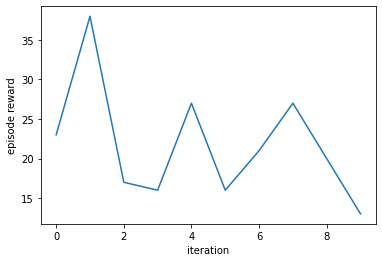

In [22]:
# 训练10轮
all_episodes = 0
logging.info('训练10轮')
episodes = 10
episode_rewards = []
chart = RewardChart()
agent = PPOAgent()
start_episodes = all_episodes
stop_episodes = episodes + all_episodes
for episode in range(start_episodes, stop_episodes):
  all_episodes += 1
  episode_reward = play_ppo(env, agent, train=True)
  episode_rewards.append(episode_reward)
  logging.info('episode:{}， episode_reward：{}, average_reward:{}'.format(all_episodes, episode_reward, np.mean(episode_rewards)))
chart.plot(episode_rewards)
# 测试
episode_rewards = [play_ppo(env, agent) for _ in range(100)]
logging.info('平均奖励为{}/{}={}'.format(sum(episode_rewards), len(episode_rewards), np.mean(episode_rewards)))

2020-06-15 15:09:21,046 : INFO : 再训练50轮
2020-06-15 15:09:26,657 : INFO : episode:20， episode_reward：16.0, average_reward:21.89090909090909
2020-06-15 15:09:33,257 : INFO : episode:30， episode_reward：29.0, average_reward:21.758333333333333
2020-06-15 15:09:40,317 : INFO : episode:40， episode_reward：12.0, average_reward:21.73846153846154
2020-06-15 15:09:53,146 : INFO : episode:50， episode_reward：25.0, average_reward:22.614285714285714
2020-06-15 15:10:02,117 : INFO : episode:60， episode_reward：26.0, average_reward:22.946666666666665
2020-06-15 15:11:06,882 : INFO : 平均奖励为2295.0/100=22.95


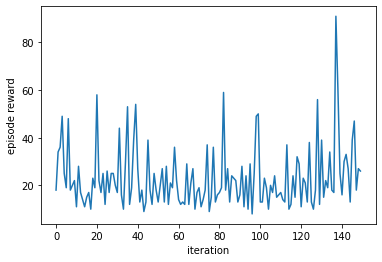

In [23]:
logging.info('再训练50轮')
episodes = 50
# episode_rewards = []
chart = RewardChart()
# agent = PPOAgent()
start_episodes = all_episodes
stop_episodes = episodes + all_episodes
for episode in range(start_episodes, stop_episodes):
  all_episodes += 1
  episode_reward = play_ppo(env, agent, train=True)
  episode_rewards.append(episode_reward)
  if all_episodes % 10 == 0:
    logging.info('episode:{}， episode_reward：{}, average_reward:{}'.format(all_episodes, episode_reward, np.mean(episode_rewards)))
chart.plot(episode_rewards)
# 测试
episode_rewards = [play_ppo(env, agent) for _ in range(100)]
logging.info('平均奖励为{}/{}={}'.format(sum(episode_rewards), len(episode_rewards), np.mean(episode_rewards)))

2020-06-15 15:11:13,033 : INFO : 再训练100轮
2020-06-15 15:11:20,670 : INFO : episode:70， episode_reward：31.0, average_reward:22.972727272727273
2020-06-15 15:11:28,080 : INFO : episode:80， episode_reward：34.0, average_reward:22.966666666666665
2020-06-15 15:11:38,376 : INFO : episode:90， episode_reward：23.0, average_reward:23.146153846153847
2020-06-15 15:11:52,749 : INFO : episode:100， episode_reward：41.0, average_reward:24.84285714285714
2020-06-15 15:12:01,766 : INFO : episode:110， episode_reward：18.0, average_reward:25.06
2020-06-15 15:12:15,816 : INFO : episode:120， episode_reward：26.0, average_reward:25.94375
2020-06-15 15:12:32,048 : INFO : episode:130， episode_reward：63.0, average_reward:27.523529411764706
2020-06-15 15:12:47,394 : INFO : episode:140， episode_reward：40.0, average_reward:28.377777777777776
2020-06-15 15:13:03,470 : INFO : episode:150， episode_reward：96.0, average_reward:29.652631578947368
2020-06-15 15:13:23,285 : INFO : episode:160， episode_reward：101.0, average_r

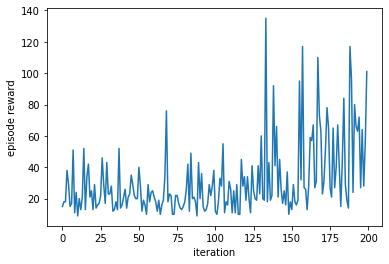

In [24]:
logging.info('再训练100轮')
episodes = 100
# episode_rewards = []
chart = RewardChart()
# agent = PPOAgent()
start_episodes = all_episodes
stop_episodes = episodes + all_episodes
for episode in range(start_episodes, stop_episodes):
  all_episodes += 1
  episode_reward = play_ppo(env, agent, train=True)
  episode_rewards.append(episode_reward)
  if all_episodes % 10 == 0:
    logging.info('episode:{}， episode_reward：{}, average_reward:{}'.format(all_episodes, episode_reward, np.mean(episode_rewards)))
chart.plot(episode_rewards)
# 测试
episode_rewards = [play_ppo(env, agent) for _ in range(100)]
logging.info('平均奖励为{}/{}={}'.format(sum(episode_rewards), len(episode_rewards), np.mean(episode_rewards)))

2020-06-15 15:16:29,521 : INFO : 再训练200轮
2020-06-15 15:16:45,258 : INFO : episode:170， episode_reward：20.0, average_reward:59.63636363636363
2020-06-15 15:17:05,535 : INFO : episode:180， episode_reward：45.0, average_reward:59.725
2020-06-15 15:17:32,992 : INFO : episode:190， episode_reward：64.0, average_reward:61.66153846153846
2020-06-15 15:17:56,845 : INFO : episode:200， episode_reward：47.0, average_reward:62.9
2020-06-15 15:18:32,817 : INFO : episode:210， episode_reward：117.0, average_reward:66.25333333333333
2020-06-15 15:19:07,791 : INFO : episode:220， episode_reward：84.0, average_reward:69.0125
2020-06-15 15:19:56,797 : INFO : episode:230， episode_reward：116.0, average_reward:73.81176470588235
2020-06-15 15:20:36,932 : INFO : episode:240， episode_reward：89.0, average_reward:76.87777777777778
2020-06-15 15:21:24,968 : INFO : episode:250， episode_reward：200.0, average_reward:81.11052631578947
2020-06-15 15:22:15,337 : INFO : episode:260， episode_reward：200.0, average_reward:84.94
2

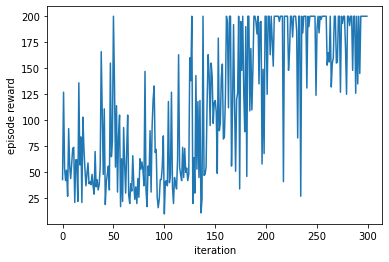

In [25]:
logging.info('再训练200轮')
episodes = 200
# episode_rewards = []
chart = RewardChart()
# agent = PPOAgent()
start_episodes = all_episodes
stop_episodes = episodes + all_episodes
for episode in range(start_episodes, stop_episodes):
  all_episodes += 1
  episode_reward = play_ppo(env, agent, train=True)
  episode_rewards.append(episode_reward)
  if all_episodes % 10 == 0:
    logging.info('episode:{}， episode_reward：{}, average_reward:{}'.format(all_episodes, episode_reward, np.mean(episode_rewards)))
chart.plot(episode_rewards)
# 测试
episode_rewards = [play_ppo(env, agent) for _ in range(100)]
logging.info('平均奖励为{}/{}={}'.format(sum(episode_rewards), len(episode_rewards), np.mean(episode_rewards)))

370多轮训练后，目标为100个回合平均奖励超过195；模型结果为196.46，已到达预期目标。

In [0]:
# env.close()